## 2 Nearest Neighbor Classfication on Real Data
Submission by Dominique Cheray & Jacqueline Wagner

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import neighbors
import scipy.stats

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2. 1 Exploring the Data

dict_keys(['target_names', 'data', 'images', 'DESCR', 'target'])
Data type: float64
Data shape: (1797, 64)


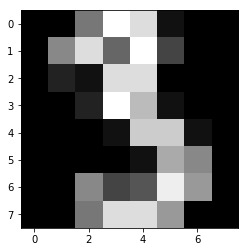

In [2]:
digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print('Data type: ' + str(data.dtype))
print('Data shape: ' + str(data.shape))

threes = images[target==3]
img = threes[0]

assert 2 == np.size(np.shape(img))

plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()

X_all = data
Y_all = target

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(digits.data, digits.target, 
                                                                     test_size=0.4, random_state=0)

### 2.2 Distance function computation using loops

In [3]:
def dist_loop(training, test):
    # N x D training, M x D test, D pixels per image, N training instances, M test instances, output N x M distance matrix
    distance_matrix = np.ndarray((training.shape[0], test.shape[0]))
    for i in range(0, training.shape[0]):
        for j in range(0, test.shape[0]):
            distance = 0
            for k in range(0, test.shape[1]):
                distance = distance + np.square(training[i][k] - test[j][k])
            distance = np.sqrt(distance)
            distance_matrix[i][j] = distance
    return distance_matrix

### 2.3 Distance function computation using vectorization

In [4]:
def dist_vec(training, test):
    # N x D training, M x D test, D pixels per image, N training instances, M test instances, output N x M distance matrix
    N = training.shape[0]
    D = training.shape[1]
    M = test.shape[0]
    # replicate the training set along a third dimension (third dimension has the size of the nr of test instances)
    training_3D = np.resize(training, (M, N, D))
    # replicate the test set along a third dimens (third dimension has the size of the nr of trainig instances)
    test_3D = np.resize(test, (N, M , D))
    # morph 3D training matrix tho it has the same shape as the 3d trainig matrix
    training_3D_transposed = np.transpose(training_3D, (1, 0, 2))
    # for each entry in the 3D test and training matrices calculate the square of the distance of these entries
    dist_mat = np.square(training_3D_transposed - test_3D)
    # to get the sum of the squares of the corresponding test and training instances sum the matrix along the axis
    # of the pixels of the images
    dist_mat = np.sum(dist_mat, axis=2)
    # finally calculate the squarerot of each entry in the distance matrix to get the euclidean distance
    dist_mat = np.sqrt(dist_mat)
    return dist_mat

In [5]:
%time dist_mat_loop = dist_loop(X_train, X_test)
%time dist_mat_vec = dist_vec(X_train, X_test)

CPU times: user 1min 21s, sys: 12 ms, total: 1min 21s
Wall time: 1min 21s
CPU times: user 200 ms, sys: 356 ms, total: 556 ms
Wall time: 556 ms


In [6]:
# substract the entrys of the two distance matrices obtained by the two different methods
dist_mat_equal = dist_mat_vec - dist_mat_loop
# test if all entrys in the resulting matrix are zero (should be the case if both methods calculate the same distances)
all_zeros = not np.any(dist_mat_equal)
print(all_zeros)

True


### 2.4 Implement the nearest neighbor classifier

In [7]:
# NN classifier given training data and according labels preditcs the classes of the test data
def nn_classifier(training_data, training_labels, test_data):
    # use the fast method to compute the distance matrix, otherwise I would drink to much coffee while waiting 
    # for the slow method to finish
    distance_matrix = dist_vec(training_data, test_data)
    # get the indices of the training instances that are closest to the test instances
    indices_min = np.argmin(distance_matrix, axis=0)
    predicted_labels = []
    # for each of the test instances give it the same class as the training instance closest to it
    for i in indices_min:
        predicted_labels.append(training_labels[i])
    return predicted_labels

# helper method to calculate the classification error given predicted labels and true labels
def calculate_error(predicted_labels, true_labels):
    error = 0
    for i in range(0, len(predicted_labels)):
        if predicted_labels[i] != true_labels[i]:
            error = error + 1
    error = error / len(predicted_labels)
    return error

In [8]:
# test the classifier for digits 1 and 3, use the test and training partitions obtained in 2.1 and filter them 
mask_train = (Y_train == 1) | (Y_train == 3)
mask_test = (Y_test == 1) | (Y_test == 3)

Y_train_13 = Y_train[mask_train]
Y_test_13 = Y_test[mask_test]
X_train_13 = X_train[mask_train]
X_test_13 = X_test[mask_test]

Y_test_13_predicted = nn_classifier(X_train_13, Y_train_13, X_test_13)

print('Error for digits 1 and 3: ' + str(calculate_error(Y_test_13_predicted, Y_test_13)))

Error for digits 1 and 3: 0.0


In [9]:
# test the classifier for digits 1 and 7, use the test and training partitions obtained in 2.1 and filter them 
mask_train = (Y_train == 1) | (Y_train == 7)
mask_test = (Y_test == 1) | (Y_test == 7)

Y_train_17 = Y_train[mask_train]
Y_test_17 = Y_test[mask_test]
X_train_17 = X_train[mask_train]
X_test_17 = X_test[mask_test]

Y_test_17_predicted = nn_classifier(X_train_17, Y_train_17, X_test_17)

print('Error for digits 1 and 7: ' + str(calculate_error(Y_test_17_predicted, Y_test_17)))

Error for digits 1 and 7: 0.0


In [10]:
Y_predicted = nn_classifier(X_train, Y_train, X_test)
print('Error for whole data: ' + str(calculate_error(Y_predicted, Y_test)))

Error for whole data: 0.012517385257301807


### 2.5 Generalize to k-nearest neighbors

In [11]:
# give the classifier the training instances, their labels, the test instances and the number of neighbors
# and it will predict you the classes of the training instances
def k_nn_classifier(training_data, training_labels, test_data, k):
    # use once again the fast method to compute the distance matrix (too much coffe is bad, you know)
    distance_matrix = dist_vec(training_data, test_data)
    # get the indices of the k nearest training instances for each test instance
    distance_matrix_indices = np.argpartition(distance_matrix, k, axis=0)[:k,:]
    # from the indices of the closest training instances for each test instance get the classes of the training instances
    # and then do a majority vote to get the class that occures most, this is then the class for the test instance
    # use fancy python array stuff, because (you know it already) for loops are evil
    predicted_labels = scipy.stats.mode(training_labels[distance_matrix_indices], axis=0)[0][0]
    return predicted_labels

In [12]:
# now use the k nn classifier from above and test it on the digits 3 and 9 (not 1 and 7 because there it makes no error)
# use the train and test partition form 2.1 and filter them
# use k = 1, 3, 5, 9, 17, 33
mask_train = (Y_train == 3) | (Y_train == 9)
mask_test = (Y_test == 3) | (Y_test == 9)

Y_train_39 = Y_train[mask_train]
Y_test_39 = Y_test[mask_test]
X_train_39 = X_train[mask_train]
X_test_39 = X_test[mask_test]

predicted_labels_k1 = k_nn_classifier(X_train_39, Y_train_39, X_test_39, 1)
print('Error for digits 3 and 9 and k=1: ' +str(calculate_error(predicted_labels_k1, Y_test_39)))

predicted_labels_k3 = k_nn_classifier(X_train_39, Y_train_39, X_test_39, 3)
print('Error for digits 3 and 9 and k=3: ' +str(calculate_error(predicted_labels_k3, Y_test_39)))

predicted_labels_k5 = k_nn_classifier(X_train_39, Y_train_39, X_test_39, 5)
print('Error for digits 3 and 9 and k=5: ' +str(calculate_error(predicted_labels_k5, Y_test_39)))

predicted_labels_k9 = k_nn_classifier(X_train_39, Y_train_39, X_test_39, 9)
print('Error for digits 3 and 9 and k=9: ' +str(calculate_error(predicted_labels_k9, Y_test_39)))

predicted_labels_k17 = k_nn_classifier(X_train_39, Y_train_39, X_test_39, 17)
print('Error for digits 3 and 9 and k=17: ' +str(calculate_error(predicted_labels_k17, Y_test_39)))

predicted_labels_k33 = k_nn_classifier(X_train_39, Y_train_39, X_test_39, 33)
print('Error for digits 3 and 9 and k=33: ' +str(calculate_error(predicted_labels_k33, Y_test_39)))

Error for digits 3 and 9 and k=1: 0.013888888888888888
Error for digits 3 and 9 and k=3: 0.006944444444444444
Error for digits 3 and 9 and k=5: 0.006944444444444444
Error for digits 3 and 9 and k=9: 0.006944444444444444
Error for digits 3 and 9 and k=17: 0.006944444444444444
Error for digits 3 and 9 and k=33: 0.020833333333333332


Using more than one k the classifier performs better but there is no difference in performance between k=3, k=5, k=9 and k=17. Chossing a k too big (in this case k=33) decreases the performance of the classifier.

### 3 Cross-validation

In [13]:
# given array of features and labels this methods splits them in n parts of roughly equal size
# actually numpy does the work for me, but the assignment said we have write a method so we did
def split_n_folds(features, labels, n):
    return np.array_split(features,n), np.array_split(labels,n)

# cross validate the k nn classifier from above and the k nn classifier from sklearn
# as input give the full featureset and the corresponding annotations
# n determines in how many folds the set is splitted for the cross validation
# then perform cross validation as describend in the assignment
# will print mean error and standard deviation of error for both of the classifiers
def cross_validate(features, labels, n):
    # create the k nn classifier from sklearn
    sklearn_nn_classifier = neighbors.KNeighborsClassifier(n_neighbors=1, p=2)
    splitted_features, splitted_labels = split_n_folds(features, labels, n)
    error_own = []
    error_sklearn = []
    for i in range(n):
        # split the features and labels into n folds
        splitted_features, splitted_labels = split_n_folds(features, labels, n)
        # determine wich fold is the test fold this time
        test_features = splitted_features[i]
        # flatten the test set for later use with sklearn classifier, because he cannot work with an array bigger than 2D
        n_test = len(test_features)
        sklearn_test_features = np.reshape(test_features, (n_test, -1))
        # remove the test set from the full features
        del splitted_features[i]
        # merge the remaining features to a training set
        training_features = np.concatenate(splitted_features)
        # again flatten the training set for sklearn
        n_features = len(training_features)
        sklearn_training_features = np.reshape(training_features, (n_features, -1))
        # get the labels for the test set
        test_labels = splitted_labels[i]
        # remove the labels of the test set from the remaining labels
        del splitted_labels[i]
        # merge the remaining labels to one set
        training_labels = np.concatenate(splitted_labels)
        # train the sklearn classifier
        sklearn_nn_classifier.fit(sklearn_training_features, training_labels)
        # use sklearn classifier to predict the labels of the test set
        predicted_sklearn = sklearn_nn_classifier.predict(sklearn_test_features)
        # use own classifier to predict the labels of the test set
        predicted_own = nn_classifier(training_features, training_labels, test_features)
        # calculate the classification error of this round for both classifiers and put them in the arrays for all errors
        error_sklearn.append(calculate_error(predicted_sklearn, test_labels))
        error_own.append(calculate_error(predicted_own, test_labels))
    print('Cross Validation with n = ' +str(n))
    print('Sklearn NN classifier \n Mean error: ' +str(np.mean(error_sklearn)) + ' Standard Deviation: ' 
          + str(np.std(error_sklearn)))
    print('Own NN classifier \n Mean error: ' +str(np.mean(error_own)) + ' Standard Deviation: ' 
          + str(np.std(error_own)))

In [14]:
# now do the cross-valdiation as described in the assignment
cross_validate(digits.images, digits.target, 2)
print()
cross_validate(digits.images, digits.target, 5)
print()
cross_validate(digits.images, digits.target, 10)

Cross Validation with n = 2
Sklearn NN classifier 
 Mean error: 0.040066171024 Standard Deviation: 0.00109066991039
Own NN classifier 
 Mean error: 0.915968869147 Standard Deviation: 0.00394214308896

Cross Validation with n = 5
Sklearn NN classifier 
 Mean error: 0.0350495202724 Standard Deviation: 0.0128664164671
Own NN classifier 
 Mean error: 0.907059733829 Standard Deviation: 0.0177065708818

Cross Validation with n = 10
Sklearn NN classifier 
 Mean error: 0.0239292364991 Standard Deviation: 0.0175860474629
Own NN classifier 
 Mean error: 0.902070142768 Standard Deviation: 0.0178949162521
